## OS classification with Ground Truth data

### Loading, Extracting and Visualizing important data

In [1]:
import pandas as pd
data= pd.read_csv('ground_truth.csv')

In [2]:
"""### filtering only human data
data = data[~data["social_id"].str.contains("bot", case=False)]
data.shape"""

'### filtering only human data\ndata = data[~data["social_id"].str.contains("bot", case=False)]\ndata.shape'

In [3]:
"""import pandas as pd
from user_agents import parse
# Extract OS name
data['os'] = data['javascript_navigator_userAgent'].apply(lambda x: parse(x).os.family)
data
"""

"import pandas as pd\nfrom user_agents import parse\n# Extract OS name\ndata['os'] = data['javascript_navigator_userAgent'].apply(lambda x: parse(x).os.family)\ndata\n"

### third party VPN API implementation

In [ ]:
import requests
import pandas as pd
from tqdm import tqdm
def enrich_with_vpn_info(df, ip_column='client_ip', api_key='your_api_key'):
    """
    Adds a new column `is_vpn` to the DataFrame based on IP intelligence from ipapi.is.

    Parameters:
        df (pd.DataFrame): The input DataFrame with a column containing IP addresses.
        ip_column (str): The name of the column containing the IPs.
        api_key (str): Your API key from ipapi.is.

    Returns:
        pd.DataFrame: Original DataFrame with an added 'is_vpn' column.
    """

    # Get unique IPs
    unique_ips = df[ip_column].dropna().unique()

    # Prepare dictionary to hold IP -> is_vpn result
    ip_vpn_map = {}

    # Query each unique IP
    for ip in tqdm(unique_ips, desc="Checking IPs", unit="IP"):
        try:
            url = f'https://api.ipapi.is?q={ip}&key={api_key}'
            response = requests.get(url, timeout=5)
            data = response.json()

            is_vpn = any([
                data.get("is_vpn", False),
                data.get("is_proxy", False),
                data.get("is_datacenter", False)
            ])
            ip_vpn_map[ip] = is_vpn

        except Exception as e:
            print(f"Error for IP {ip}: {e}")
            ip_vpn_map[ip] = False  # Default to False if error




































            

    # Map back to DataFrame
    df['is_vpn'] = df[ip_column].map(ip_vpn_map)

    return df
data = enrich_with_vpn_info(data, ip_column='client_ip', api_key='' )

Checking IPs: 100%|██████████| 200/200 [01:20<00:00,  2.48IP/s]


In [16]:
# Extract window-size features into separate dataset
window_size_cols =list(data.columns[data.columns.str.endswith('window_size', na=False)])
window_size_df = data[['client_ip','os',"is_vpn"] + window_size_cols]
window_size_df

,client_ip,os,is_vpn,flw_min_window_size,flw_max_window_size,flw_mean_window_size,flw_std_window_size,flw_bwd_min_window_size,flw_bwd_max_window_size,flw_bwd_mean_window_size,flw_bwd_std_window_size
0,115.21.222.242,Mac Os,False,2018.0,65535.0,3914.823529,10726.698542,163.0,21120.0,775.600000,3489.257295
1,121.141.102.226,Mac Os,False,2018.0,65535.0,3427.695652,9258.412593,163.0,21120.0,1106.595745,2995.618394
2,121.141.102.226,Mac Os,False,2018.0,65535.0,5071.619048,13520.027066,163.0,21120.0,1066.458333,4182.276284
3,115.21.222.242,Ubuntu,False,472.0,64240.0,5036.500000,16420.098950,163.0,21120.0,2258.700000,6287.100000
4,213.230.93.159,Mac Os,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
4997,115.21.222.242,Mac Os,False,2018.0,65535.0,3914.852941,10726.693381,163.0,21120.0,987.745098,2889.841266
4998,115.21.222.242,Mac Os,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4999,115.21.222.242,Mac Os,False,2018.0,65535.0,3201.618182,8482.501300,163.0,21120.0,867.355932,2694.659909
5000,115.21.222.242,Ubuntu,False,468.0,64240.0,695.387900,3797.518234,163.0,21120.0,3544.681818,2395.203249


### Visualizing the data


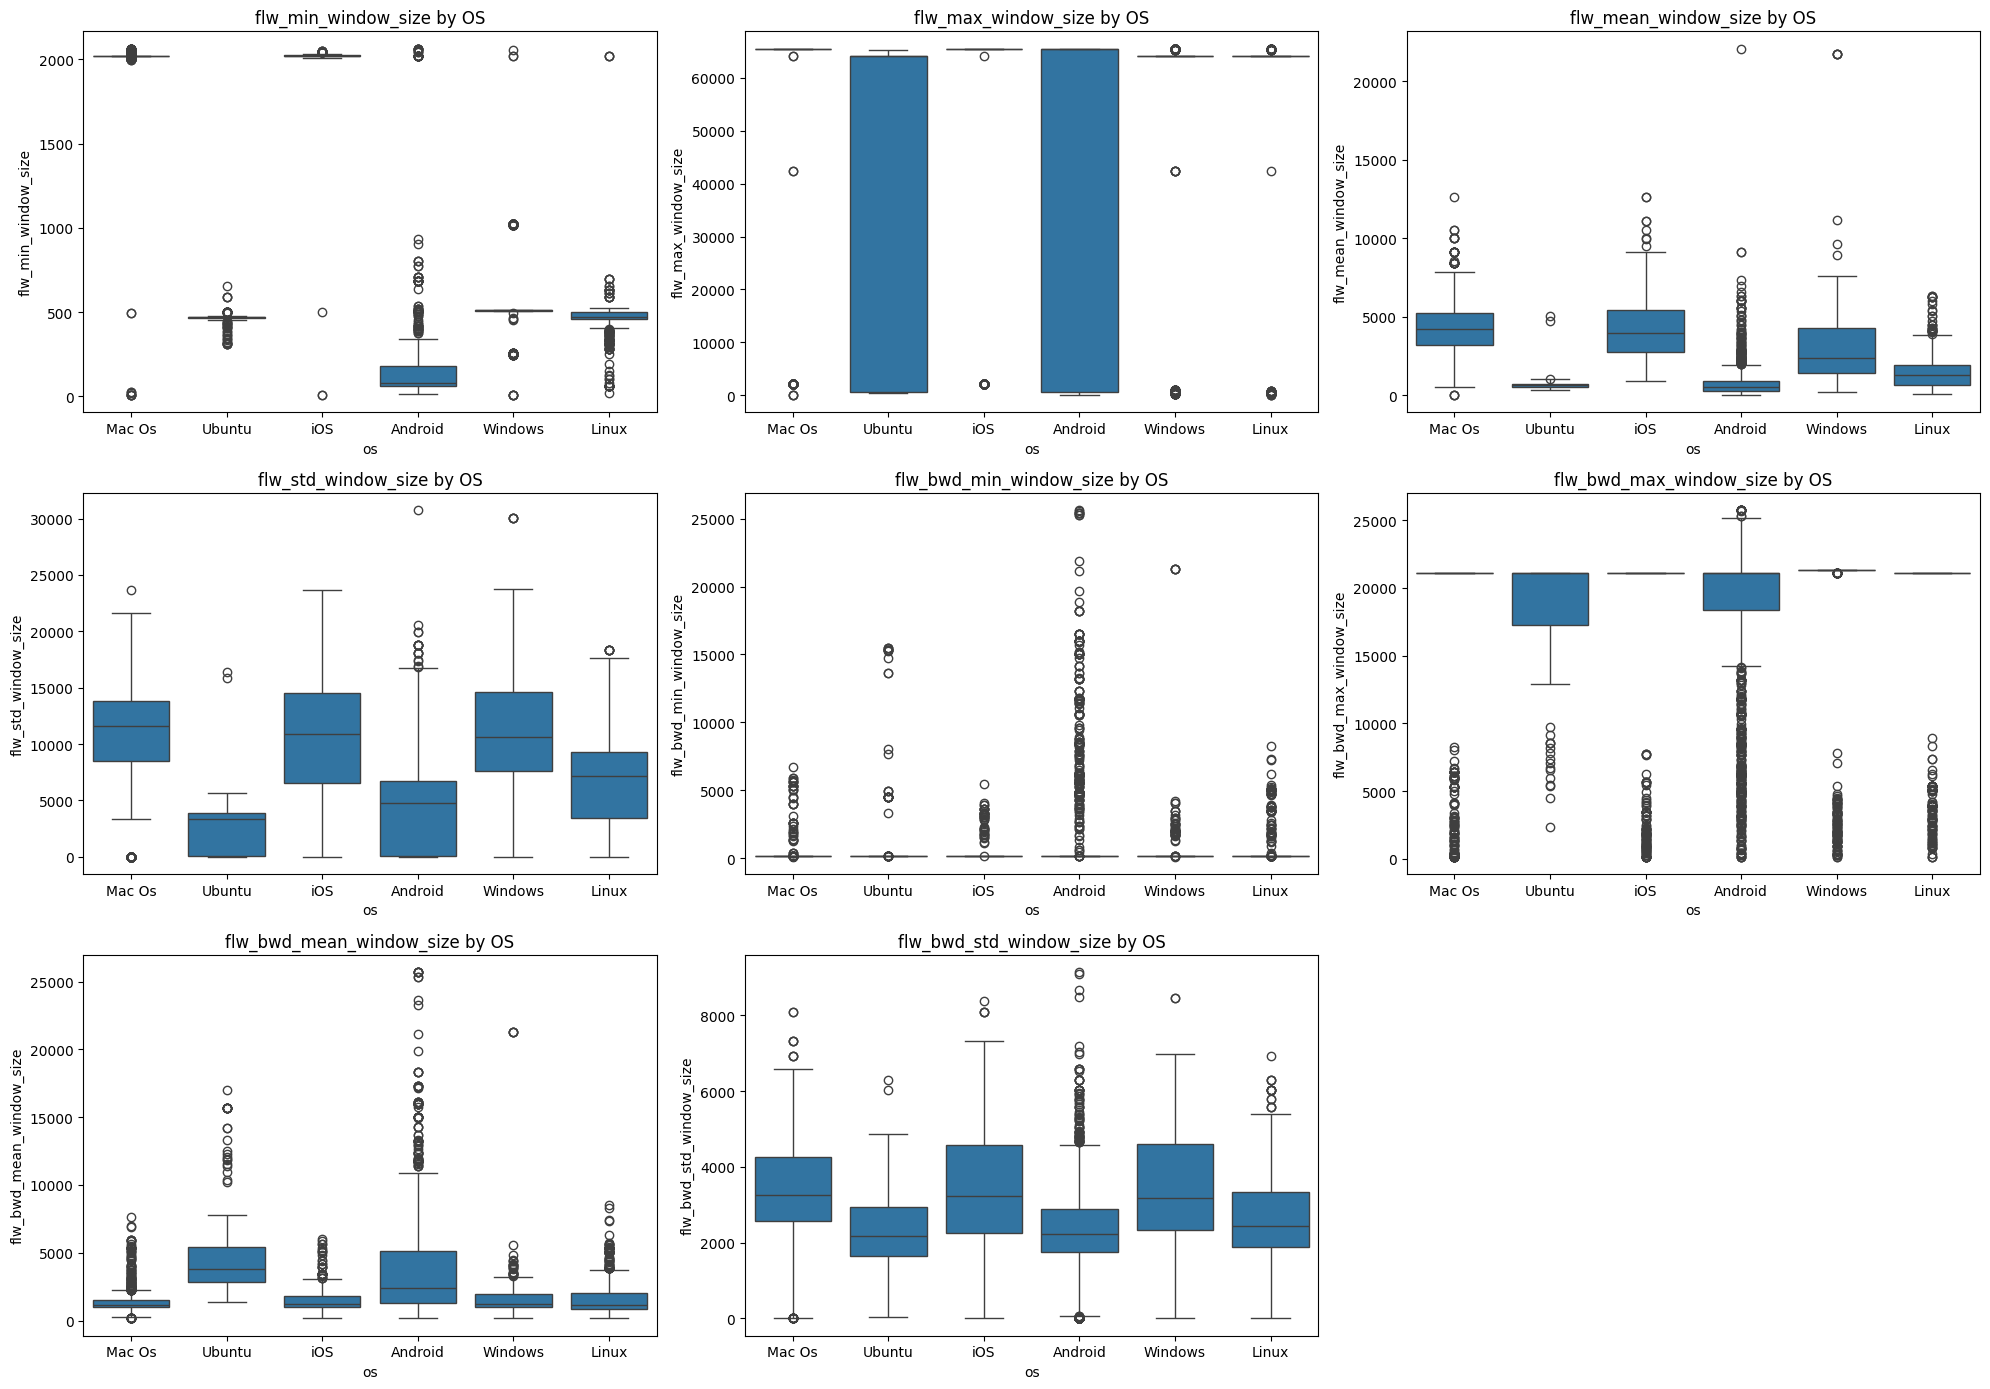

In [6]:
# Visualizing window-size distribution for OS names
import matplotlib.pyplot as plt
import seaborn as sns
rows = 3
cols = 3

fig, axes = plt.subplots(rows, cols, figsize=(20, 14))
axes = axes.flatten()

for i, feature in enumerate(window_size_cols):
    sns.boxplot(x='os', y=feature, data=data, ax=axes[i])
    axes[i].set_title(f'{feature} by OS')

# Hide any unused subplots
for j in range(len(window_size_cols), rows * cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### Threshold for WIndows

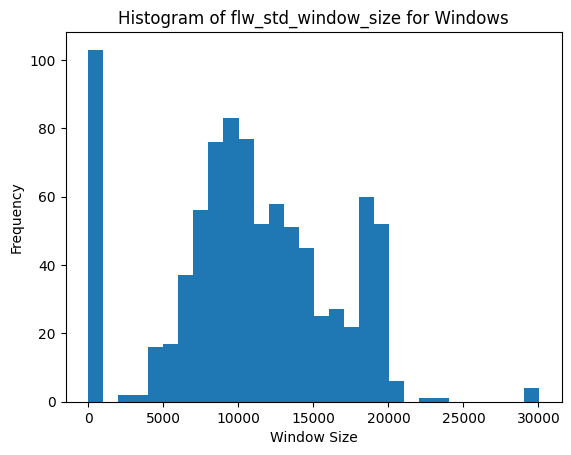

In [19]:
windows_df = data[data['os'] == 'Windows']

# Replace 'window_size_feature' with the actual column name
plt.hist(windows_df['flw_std_window_size'], bins=30)
plt.title('Histogram of flw_std_window_size for Windows')
plt.xlabel('Window Size')
plt.ylabel('Frequency')
plt.show()


In [8]:
windows_df

,client_ip,os,timestamp,flw_exported_timestamp,flw_ip_src,flw_ip_dst,flw_prt_src,flw_prt_dst,flw_proto,flw_num_pkts,...,flw_std_ttl,flw_bwd_min_ttl,flw_bwd_max_ttl,flw_bwd_mean_ttl,flw_bwd_std_ttl,flw_tlsFP_ja3_text,flw_tlsFP_ja3_hash,flw_tlsFP_ja3n_text,flw_tlsFP_ja3n_hash,is_vpn
9,115.21.222.242,Windows,2024-11-30 12:58:43.331000+00:00,1.732971e+12,115.21.222.242,35.189.75.187,59747.0,443.0,TCP,35.0,...,0.0,63.0,63.0,63.0,0.0,"771,4865-4866-4867-49195-49199-49196-49200-523...",12f3b63263667616a2a9403375e09ebf,"771,4865-4866-4867-49195-49199-49196-49200-523...",dee19b855b658c6aa0f575eda2525e19,False
12,115.21.222.242,Windows,2024-11-30 13:00:46.437000+00:00,1.732972e+12,115.21.222.242,35.189.75.187,59844.0,443.0,TCP,20.0,...,0.0,63.0,63.0,63.0,0.0,"771,4865-4866-4867-49195-49199-49196-49200-523...",bb00e836d01423008786b17c3b136f12,"771,4865-4866-4867-49195-49199-49196-49200-523...",dee19b855b658c6aa0f575eda2525e19,False
13,115.21.222.242,Windows,2024-11-30 13:56:23.357000+00:00,1.732975e+12,115.21.222.242,35.189.75.187,62547.0,443.0,TCP,43.0,...,0.0,63.0,63.0,63.0,0.0,"771,4865-4866-4867-49195-49199-49196-49200-523...",9b587be67b39d7eed5f76a327524f471,"771,4865-4866-4867-49195-49199-49196-49200-523...",dee19b855b658c6aa0f575eda2525e19,False
36,115.21.222.242,Windows,2024-12-01 10:25:36.055000+00:00,1.733049e+12,115.21.222.242,35.189.75.187,61721.0,443.0,TCP,12.0,...,0.0,63.0,63.0,63.0,0.0,NaN,NaN,NaN,NaN,False
37,171.224.178.127,Windows,2024-12-01 18:56:26.250000+00:00,1.733079e+12,171.224.178.127,35.189.75.187,17282.0,443.0,TCP,54.0,...,0.0,63.0,63.0,63.0,0.0,"771,4865-4866-4867-49195-49199-49196-49200-523...",3cfebda38adadd735fc395d29fc75eca,"771,4865-4866-4867-49195-49199-49196-49200-523...",dee19b855b658c6aa0f575eda2525e19,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4981,115.21.222.242,Windows,2025-01-28 08:44:01.824000+00:00,1.738054e+12,115.21.222.242,35.189.75.187,64484.0,443.0,TCP,66.0,...,0.0,63.0,63.0,63.0,0.0,"771,4865-4866-4867-49195-49199-49196-49200-523...",094e8655946cead065229a61f36666a4,"771,4865-4866-4867-49195-49199-49196-49200-523...",dee19b855b658c6aa0f575eda2525e19,False
4982,115.21.222.242,Windows,2025-01-29 03:58:29.976000+00:00,1.738123e+12,115.21.222.242,35.189.75.187,35362.0,443.0,TCP,75.0,...,0.0,63.0,63.0,63.0,0.0,"771,4865-4866-4867-49195-49199-49196-49200-523...",0493c52aabb249c52207401c2e8c1e0d,"771,4865-4866-4867-49195-49199-49196-49200-523...",dee19b855b658c6aa0f575eda2525e19,False
4983,115.21.222.242,Windows,2025-01-29 03:58:52.493000+00:00,1.738123e+12,115.21.222.242,35.189.75.187,35362.0,443.0,TCP,175.0,...,0.0,63.0,63.0,63.0,0.0,"771,4865-4866-4867-49195-49199-49196-49200-523...",0493c52aabb249c52207401c2e8c1e0d,"771,4865-4866-4867-49195-49199-49196-49200-523...",dee19b855b658c6aa0f575eda2525e19,False
4984,115.21.222.242,Windows,2025-01-29 03:59:18.432000+00:00,1.738123e+12,115.21.222.242,35.189.75.187,35362.0,443.0,TCP,224.0,...,0.0,63.0,63.0,63.0,0.0,"771,4865-4866-4867-49195-49199-49196-49200-523...",0493c52aabb249c52207401c2e8c1e0d,"771,4865-4866-4867-49195-49199-49196-49200-523...",dee19b855b658c6aa0f575eda2525e19,False


In [9]:
#correlations for windows
print('flow-feature correlations for Windows devices:\n')
data['is_windows'] = (data['os'] == 'Windows').astype(int)
correlations = data[window_size_cols + ['is_windows']].corr()
print(correlations['is_windows'].sort_values(ascending=False))

flow-feature correlations for Windows devices:

is_windows                  1.000000
flw_std_window_size         0.236483
flw_bwd_std_window_size     0.165047
flw_mean_window_size        0.116453
flw_max_window_size         0.067566
flw_bwd_max_window_size     0.054301
flw_bwd_min_window_size    -0.093102
flw_bwd_mean_window_size   -0.146531
flw_min_window_size        -0.211080
Name: is_windows, dtype: float64


In [10]:
def check_outliers_iqr(os_nme, feature):
    os_flw = data[data['os'] == os_nme]
    Q1 = os_flw[feature].quantile(0.10)
    Q3 = os_flw[feature].quantile(0.75)
    print(Q1, Q3)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR

    outliers = os_flw[(os_flw[feature] > Q1)&(os_flw[feature] < Q3)]

    return outliers
outliers = check_outliers_iqr('Windows', 'flw_std_window_size')
outliers

1.699673171197595 14576.944275273614


,client_ip,os,timestamp,flw_exported_timestamp,flw_ip_src,flw_ip_dst,flw_prt_src,flw_prt_dst,flw_proto,flw_num_pkts,...,flw_bwd_min_ttl,flw_bwd_max_ttl,flw_bwd_mean_ttl,flw_bwd_std_ttl,flw_tlsFP_ja3_text,flw_tlsFP_ja3_hash,flw_tlsFP_ja3n_text,flw_tlsFP_ja3n_hash,is_vpn,is_windows
9,115.21.222.242,Windows,2024-11-30 12:58:43.331000+00:00,1.732971e+12,115.21.222.242,35.189.75.187,59747.0,443.0,TCP,35.0,...,63.0,63.0,63.0,0.0,"771,4865-4866-4867-49195-49199-49196-49200-523...",12f3b63263667616a2a9403375e09ebf,"771,4865-4866-4867-49195-49199-49196-49200-523...",dee19b855b658c6aa0f575eda2525e19,False,1
12,115.21.222.242,Windows,2024-11-30 13:00:46.437000+00:00,1.732972e+12,115.21.222.242,35.189.75.187,59844.0,443.0,TCP,20.0,...,63.0,63.0,63.0,0.0,"771,4865-4866-4867-49195-49199-49196-49200-523...",bb00e836d01423008786b17c3b136f12,"771,4865-4866-4867-49195-49199-49196-49200-523...",dee19b855b658c6aa0f575eda2525e19,False,1
13,115.21.222.242,Windows,2024-11-30 13:56:23.357000+00:00,1.732975e+12,115.21.222.242,35.189.75.187,62547.0,443.0,TCP,43.0,...,63.0,63.0,63.0,0.0,"771,4865-4866-4867-49195-49199-49196-49200-523...",9b587be67b39d7eed5f76a327524f471,"771,4865-4866-4867-49195-49199-49196-49200-523...",dee19b855b658c6aa0f575eda2525e19,False,1
37,171.224.178.127,Windows,2024-12-01 18:56:26.250000+00:00,1.733079e+12,171.224.178.127,35.189.75.187,17282.0,443.0,TCP,54.0,...,63.0,63.0,63.0,0.0,"771,4865-4866-4867-49195-49199-49196-49200-523...",3cfebda38adadd735fc395d29fc75eca,"771,4865-4866-4867-49195-49199-49196-49200-523...",dee19b855b658c6aa0f575eda2525e19,False,1
45,175.124.145.87,Windows,2024-12-02 06:08:01.829000+00:00,1.733120e+12,175.124.145.87,35.189.75.187,57919.0,443.0,TCP,69.0,...,63.0,63.0,63.0,0.0,"771,4865-4866-4867-49195-49199-49196-49200-523...",0ba909d81eb8b9edad4aa818a92061d8,"771,4865-4866-4867-49195-49199-49196-49200-523...",dee19b855b658c6aa0f575eda2525e19,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4981,115.21.222.242,Windows,2025-01-28 08:44:01.824000+00:00,1.738054e+12,115.21.222.242,35.189.75.187,64484.0,443.0,TCP,66.0,...,63.0,63.0,63.0,0.0,"771,4865-4866-4867-49195-49199-49196-49200-523...",094e8655946cead065229a61f36666a4,"771,4865-4866-4867-49195-49199-49196-49200-523...",dee19b855b658c6aa0f575eda2525e19,False,1
4982,115.21.222.242,Windows,2025-01-29 03:58:29.976000+00:00,1.738123e+12,115.21.222.242,35.189.75.187,35362.0,443.0,TCP,75.0,...,63.0,63.0,63.0,0.0,"771,4865-4866-4867-49195-49199-49196-49200-523...",0493c52aabb249c52207401c2e8c1e0d,"771,4865-4866-4867-49195-49199-49196-49200-523...",dee19b855b658c6aa0f575eda2525e19,False,1
4983,115.21.222.242,Windows,2025-01-29 03:58:52.493000+00:00,1.738123e+12,115.21.222.242,35.189.75.187,35362.0,443.0,TCP,175.0,...,63.0,63.0,63.0,0.0,"771,4865-4866-4867-49195-49199-49196-49200-523...",0493c52aabb249c52207401c2e8c1e0d,"771,4865-4866-4867-49195-49199-49196-49200-523...",dee19b855b658c6aa0f575eda2525e19,False,1
4984,115.21.222.242,Windows,2025-01-29 03:59:18.432000+00:00,1.738123e+12,115.21.222.242,35.189.75.187,35362.0,443.0,TCP,224.0,...,63.0,63.0,63.0,0.0,"771,4865-4866-4867-49195-49199-49196-49200-523...",0493c52aabb249c52207401c2e8c1e0d,"771,4865-4866-4867-49195-49199-49196-49200-523...",dee19b855b658c6aa0f575eda2525e19,False,1


In [11]:
vpn_win = outliers[outliers["is_vpn"] == True]
vpn_win.describe()

,flw_exported_timestamp,flw_prt_src,flw_prt_dst,flw_num_pkts,flw_bwd_num_pkts,flw_min_iat,flw_max_iat,flw_mean_iat,flw_std_iat,flw_bwd_min_iat,...,flw_bwd_flow_duration_ms,flw_min_ttl,flw_max_ttl,flw_mean_ttl,flw_std_ttl,flw_bwd_min_ttl,flw_bwd_max_ttl,flw_bwd_mean_ttl,flw_bwd_std_ttl,is_windows
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
non_vpn_win = outliers[outliers["is_vpn"] == False]
non_vpn_win.describe()

,flw_exported_timestamp,flw_prt_src,flw_prt_dst,flw_num_pkts,flw_bwd_num_pkts,flw_min_iat,flw_max_iat,flw_mean_iat,flw_std_iat,flw_bwd_min_iat,...,flw_bwd_flow_duration_ms,flw_min_ttl,flw_max_ttl,flw_mean_ttl,flw_std_ttl,flw_bwd_min_ttl,flw_bwd_max_ttl,flw_bwd_mean_ttl,flw_bwd_std_ttl,is_windows
count,5.650000e+02,565.000000,565.0,565.000000,565.000000,565.0,565.000000,565.000000,565.000000,565.0,...,565.000000,565.000000,565.000000,565.000000,565.0,565.0,565.0,565.0,565.0,565.0
mean,1.735081e+12,41550.587611,443.0,52.725664,61.026549,0.0,20505.778761,643.939350,3238.763082,0.0,...,29058.260177,117.145133,117.145133,117.145133,0.0,63.0,63.0,63.0,0.0,1.0
std,8.239959e+08,18643.929448,0.0,39.415240,39.767734,0.0,13618.955015,515.099074,2218.996568,0.0,...,25364.785169,18.024515,18.024515,18.024515,0.0,0.0,0.0,0.0,0.0,0.0
min,1.732971e+12,1114.000000,443.0,4.000000,5.000000,0.0,105.000000,9.423077,30.232058,0.0,...,5.000000,49.000000,49.000000,49.000000,0.0,63.0,63.0,63.0,0.0,1.0
25%,1.735030e+12,28093.000000,443.0,28.000000,32.000000,0.0,11218.000000,292.512500,1730.434487,0.0,...,13729.000000,118.000000,118.000000,118.000000,0.0,63.0,63.0,63.0,0.0,1.0
50%,1.735293e+12,48585.000000,443.0,41.000000,52.000000,0.0,17873.000000,536.512500,2826.165298,0.0,...,20894.000000,119.000000,119.000000,119.000000,0.0,63.0,63.0,63.0,0.0,1.0
75%,1.735524e+12,57304.000000,443.0,61.000000,77.000000,0.0,29108.000000,822.653846,4474.288851,0.0,...,36838.000000,120.000000,120.000000,120.000000,0.0,63.0,63.0,63.0,0.0,1.0
max,1.738204e+12,65524.000000,443.0,340.000000,250.000000,0.0,59347.000000,2975.444444,12009.679684,0.0,...,193450.000000,241.000000,241.000000,241.000000,0.0,63.0,63.0,63.0,0.0,1.0


### Threshold for MacOS


(0, 81)


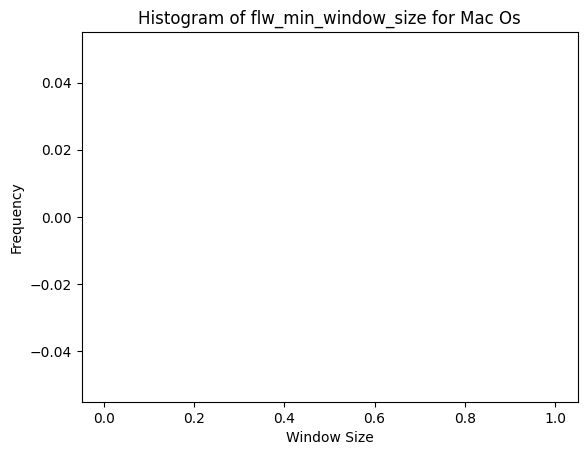

In [13]:
macos_df = data[data['os'] == 'Mac OS X']
print(macos_df.shape)
# Replace 'window_size_feature' with the actual column name
plt.hist(macos_df['flw_min_window_size'], bins=30)
plt.title('Histogram of flw_min_window_size for Mac Os')
plt.xlabel('Window Size')
plt.ylabel('Frequency')
plt.show()

In [14]:
#correlations for macOS
print('flow-feature correlations for MacOS devices:\n')
ws_on['is_macos'] = (ws_on['os'] == 'Mac OS X').astype(int)
correlations = ws_on[size_cols + ['is_macos']].corr()
print(correlations['is_macos'].sort_values(ascending=False))

flow-feature correlations for MacOS devices:



NameError: name 'ws_on' is not defined

In [ ]:
macos_outliers = macos_df[macos_df['flw_min_window_size'] < 1000]
macos_outliers = macos_outliers[['social_id','client_ip','os',"is_vpn"]+size_cols]
macos_outliers

* when we have min window size lower than 1000, we can flag mac os users as vpn 

In [ ]:
mac_vpn = macos_df[macos_df["is_vpn"] == True]
mac_vpn = mac_vpn[['social_id','client_ip','os',"is_vpn"]+size_cols]
mac_vpn

### Threshold for Ubuntu

In [ ]:
#correlations for Ubuntu
ws_on['is_ubuntu'] = (ws_on['os'] == 'Ubuntu').astype(int)
correlations = ws_on[size_cols + ['is_ubuntu']].corr()
print(correlations['is_ubuntu'].sort_values(ascending=False))

is_ubuntu                   1.000000
flw_bwd_mean_window_size    0.175706
flw_bwd_min_window_size     0.059836
flw_bwd_max_window_size     0.013313
flw_max_window_size        -0.037029
flw_bwd_std_window_size    -0.061454
flw_min_window_size        -0.101552
flw_mean_window_size       -0.149461
flw_std_window_size        -0.167221
Name: is_ubuntu, dtype: float64


/tmp/ipykernel_109892/1941424164.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ws_on['is_ubuntu'] = (ws_on['os'] == 'Ubuntu').astype(int)


(162, 1184)


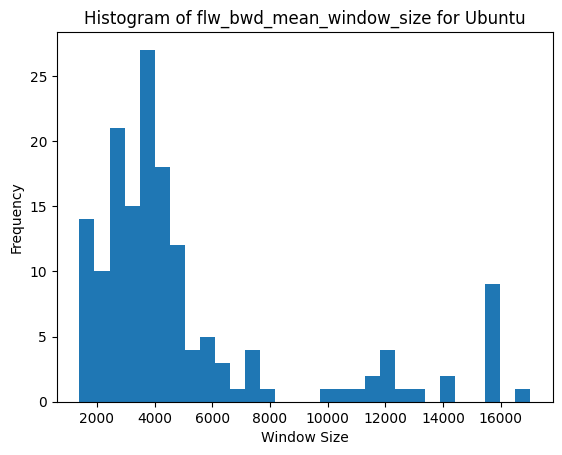

In [ ]:
ubuntu_df = data[data['os'] == 'Ubuntu']
print(ubuntu_df.shape)
# Replace 'window_size_feature' with the actual column name
plt.hist(ubuntu_df['flw_bwd_mean_window_size'], bins=30)
plt.title('Histogram of flw_bwd_mean_window_size for Ubuntu')
plt.xlabel('Window Size')
plt.ylabel('Frequency')
plt.show()

In [ ]:
ubuntu_df

* Need to collect more data to determine the threshold for Ubuntu

In [ ]:
# list ubuntu, flw min win size is less than 1000
lower_ubuntu = data['flw_bwd_mean_window_size'].quantile(0.75)
print(lower_ubuntu)
ubuntu_threshold = data[(data['os'] == 'Ubuntu')  & (data['flw_bwd_mean_window_size'] < lower_ubuntu) ]
outlier_ubuntu_ips = ubuntu_threshold[['client_ip'] + size_cols]['client_ip'].value_counts().index.tolist()

check_ip_vpn(outlier_ubuntu_ips)

# result: there is no vpn



### Threshold for Android

(1574, 1184)


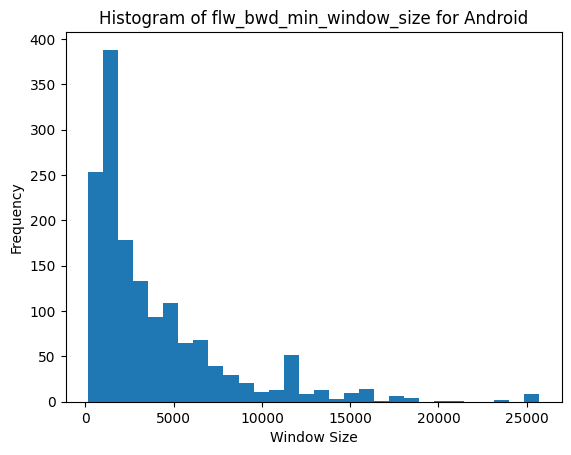

In [ ]:
android_df = data[data['os'] == 'Android']
print(android_df.shape)
# Replace 'window_size_feature' with the actual column name
plt.hist(android_df['flw_bwd_mean_window_size'], bins=30)
plt.title('Histogram of flw_bwd_min_window_size for Android')
plt.xlabel('Window Size')
plt.ylabel('Frequency')
plt.show()

In [ ]:
ws_on['is_android'] = (ws_on['os'] == 'Android').astype(int)
correlations = ws_on[size_cols + ['is_android']].corr()
print(correlations['is_android'].sort_values(ascending=False))

is_android                  1.000000
flw_bwd_mean_window_size    0.368159
flw_bwd_min_window_size     0.232215
flw_bwd_max_window_size    -0.045256
flw_max_window_size        -0.125864
flw_bwd_std_window_size    -0.247168
flw_std_window_size        -0.390238
flw_mean_window_size       -0.513358
flw_min_window_size        -0.595422
Name: is_android, dtype: float64


/tmp/ipykernel_109892/1567549541.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ws_on['is_android'] = (ws_on['os'] == 'Android').astype(int)


In [ ]:
# list Android
upper_android = data['flw_bwd_mean_window_size'].quantile(0.50)
lower_android = data['flw_bwd_mean_window_size'].quantile(0.25)
android_threshold = data[(data['os'] == 'Android')  & (data['flw_bwd_mean_window_size'] > lower_android) & (data['flw_bwd_mean_window_size'] < upper_android) ]
outlier_android_ips = android_threshold[['client_ip'] + size_cols]['client_ip'].value_counts().index.tolist()

check_ip_vpn(outlier_android_ips)

# result: there is no vpn



In [ ]:
android_vpn = android_df[android_df["is_vpn"] == True]
android_vpn = android_vpn[['social_id','client_ip','os',"is_vpn"]+size_cols]
android_vpn

,social_id,client_ip,os,is_vpn,flw_min_window_size,flw_max_window_size,flw_mean_window_size,flw_std_window_size,flw_bwd_min_window_size,flw_bwd_max_window_size,flw_bwd_mean_window_size,flw_bwd_std_window_size
41,human_bobur_androidAvastsecure,103.107.199.114,Android,True,16.0,64240.0,405.236364,4984.657588,156.0,21120.0,1424.699387,1858.811838
90,human_bobur_galaxy21Avastsecure,203.10.98.254,Android,True,16.0,64240.0,430.348387,5141.928260,163.0,21120.0,1499.248366,1997.746699
165,human_bobur_galaxys21Avastsecure,203.10.98.254,Android,True,16.0,64240.0,462.000000,5333.384291,156.0,21120.0,1276.384615,1967.645577
339,human_bobur_galaxys21Avast,103.107.199.114,Android,True,16.0,64240.0,171.506053,3156.428145,163.0,21120.0,1419.662531,1103.429787
428,human_bobur_galaxys21Avast,103.107.199.114,Android,True,16.0,64240.0,447.033557,5243.749540,163.0,21120.0,1563.896774,1943.836852
434,human_bobur_galaxyS21Operamini,141.0.9.79,Android,True,248.0,64240.0,754.803150,5655.710863,155.0,21120.0,1670.655172,2068.335701
536,human_bobur_galaxyS21Operamini,141.0.9.145,Android,True,248.0,64240.0,754.803150,5655.710863,155.0,21120.0,2093.340909,2082.450279
537,human_bobur_galaxyS21Avast,203.10.98.254,Android,True,16.0,64240.0,455.890411,5296.981988,157.0,21120.0,1566.265734,2037.401210
2789,human_bobur_S21_Avast_cronos,203.10.98.254,Android,True,16.0,64240.0,502.545455,5568.767260,155.0,21120.0,1318.200000,2086.594247
2790,human_bobur_S21_Avast_side_xyz,203.10.98.254,Android,True,16.0,64240.0,220.535032,3618.594106,155.0,21120.0,3954.363946,2599.312912


In [ ]:
non_vpn_win = android_df[android_df["is_vpn"] == False]
non_vpn_win = non_vpn_win[['social_id','client_ip','os',"is_vpn"]+size_cols]
non_vpn_win

,social_id,client_ip,os,is_vpn,flw_min_window_size,flw_max_window_size,flw_mean_window_size,flw_std_window_size,flw_bwd_min_window_size,flw_bwd_max_window_size,flw_bwd_mean_window_size,flw_bwd_std_window_size
7,human_akmal201_android,185.139.138.223,Android,False,64.0,65535.0,327.788845,4124.066153,157.0,21120.0,3655.776119,2578.075456
10,human_gofurjon_android,211.36.156.56,Android,False,64.0,65535.0,345.905738,4181.882670,156.0,21120.0,1754.159091,1750.988782
11,human_gofurjon_android,211.36.156.56,Android,False,64.0,65535.0,366.457399,4373.826284,158.0,21120.0,1792.057416,1769.292756
17,human_mironshoh_samsungphone,106.102.142.206,Android,False,64.0,65535.0,297.912162,3798.250353,156.0,21120.0,3068.286550,2149.592383
18,human_unknown_android,118.103.215.38,Android,False,76.0,78.0,77.975155,0.221522,163.0,3125.0,1644.707317,1040.243317
...,...,...,...,...,...,...,...,...,...,...,...,...
5663,human_humoyun_samsungA21_kakaotalk_side_xyz,115.21.222.242,Android,False,75.0,86.0,81.625000,3.975402,156.0,14223.0,6669.924242,4134.423095
6910,human_shohruh_s22Chrome_cronos,115.21.222.242,Android,False,128.0,65535.0,1363.888889,8814.582559,148.0,21120.0,763.365385,2863.518559
7775,emulator_emulator_desktopCHrome_new_side_xyz,115.21.222.242,Android,False,470.0,64240.0,2531.645161,11266.355908,163.0,21120.0,861.566667,3761.896629
7782,human_humoyun_samsungA21SamsungInternet,115.21.222.242,Android,False,64.0,65535.0,371.098655,4373.515088,156.0,21120.0,3339.686695,2539.081447


### Threshold for iOS

(597, 1184)


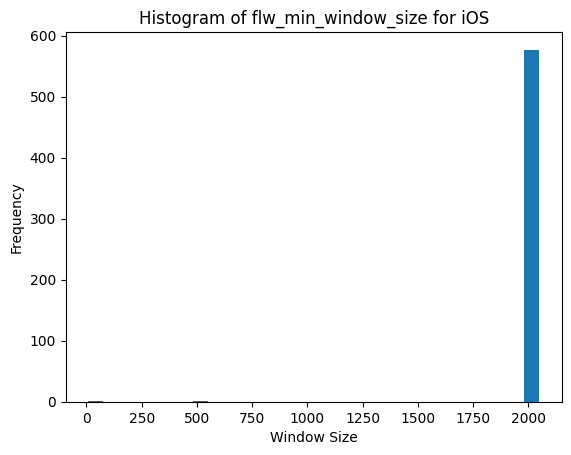

In [ ]:
ios_df = data[data['os'] == 'iOS']
print(ios_df.shape)
# Replace 'window_size_feature' with the actual column name
plt.hist(ios_df['flw_min_window_size'], bins=30)
plt.title('Histogram of flw_min_window_size for iOS')
plt.xlabel('Window Size')
plt.ylabel('Frequency')
plt.show()

In [ ]:
ios_df

In [ ]:
#correlations for iOS
print('flow-feature correlations for iOS devices:\n')
ws_on['is_ios'] = (ws_on['os'] == 'iOS').astype(int)
correlations = ws_on[size_cols + ['is_ios']].corr()
print(correlations['is_ios'].sort_values(ascending=False))

flow-feature correlations for iOS devices:

is_ios                      1.000000
flw_min_window_size         0.482136
flw_mean_window_size        0.298015
flw_std_window_size         0.132291
flw_bwd_std_window_size     0.091476
flw_max_window_size         0.000994
flw_bwd_max_window_size    -0.048962
flw_bwd_min_window_size    -0.069202
flw_bwd_mean_window_size   -0.117004
Name: is_ios, dtype: float64


/tmp/ipykernel_109892/1093027219.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ws_on['is_ios'] = (ws_on['os'] == 'iOS').astype(int)


In [ ]:
# list Android
ios_threshold = data[(data['os'] == 'iOS')  & (data['flw_min_window_size'] < 1600) ]
outlier_ios_ips = ios_threshold[['client_ip'] + size_cols]['client_ip'].value_counts().index.tolist()

check_ip_vpn(outlier_ios_ips)




* Need to collect more data to determine the threshold for iOS

### Threshold for Linux

(673, 1184)


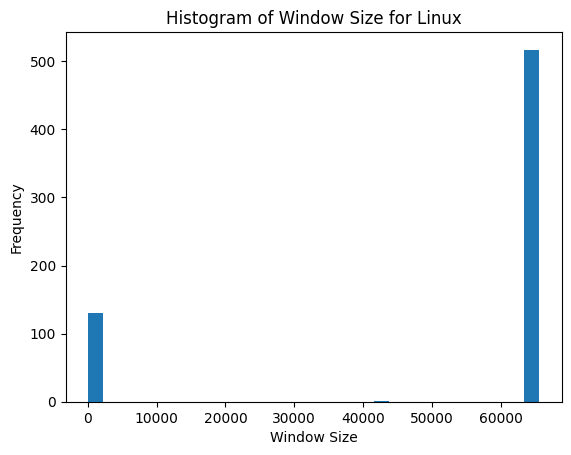

In [ ]:
linux_df = data[data['os'] == 'Linux']
print(linux_df.shape)
plt.hist(linux_df['flw_max_window_size'], bins=30)
plt.title('Histogram of Window Size for Linux')
plt.xlabel('Window Size')
plt.ylabel('Frequency')
plt.show()


In [ ]:
#correlations for Linux
ws_on['is_linux'] = (ws_on['os'] == 'Linux').astype(int)
correlations = ws_on[size_cols + ['is_linux']].corr()
print(correlations['is_linux'].sort_values(ascending=False))

is_linux                    1.000000
flw_max_window_size        -0.026783
flw_bwd_min_window_size    -0.031420
flw_bwd_max_window_size    -0.043288
flw_bwd_mean_window_size   -0.088316
flw_std_window_size        -0.093965
flw_bwd_std_window_size    -0.094004
flw_mean_window_size       -0.175062
flw_min_window_size        -0.217778
Name: is_linux, dtype: float64


/tmp/ipykernel_109892/678274619.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ws_on['is_linux'] = (ws_on['os'] == 'Linux').astype(int)


In [ ]:
# get in list those with LINUX and flw max win size
linux_threshold = data[(data['os'] == 'Linux')  & (data['flw_max_window_size'] < 60000)]
outlier_linux_ips = linux_threshold[['client_ip'] + size_cols]['client_ip'].value_counts().index.tolist()
check_ip_vpn(outlier_linux_ips)



In [ ]:
ios_df